<a href="https://colab.research.google.com/github/Mayank01/EVA/blob/master/Session11/Assignment/Assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 11 : Training & Learning Rate

###In these NoteBook we show:
> 1. SGD + Momentum
> 2. LR Finder to get best Start training accuracy
> 3. Add Cutout to model 
> 4. Run GradCam to get 25 misclassified images

##Importing and Installing Keras and related core assualts for building Neural Network

In [0]:
from keras import backend as k
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017)
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import os

from keras import optimizers
from keras.callbacks import Callback

Using TensorFlow backend.


###Loading Cifar10 Datasets into train and test data

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels = train_features.shape
num_test , _, _, _ = test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 7s 0us/step


###Printing Number of classes, rows, Cols, channels, Num of training and Test Data and Train 

In [0]:
print(num_classes)
print(img_rows)
print(img_cols)
print(img_channels) 
print(num_train)
print(num_test)
print(train_features.shape)

10
32
32
3
50000
10000
(50000, 32, 32, 3)


In [0]:
print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (train_features.mean(), train_features.std(), test_features.mean(), test_features.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(train_features)

# demonstrate effect on a single batch of samples
iterator = datagen.flow(train_features, train_labels, batch_size=128)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(train_features, train_labels, batch_size=len(train_features), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(128, 32, 32, 3) 0.013107389 1.0013419
(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
iterator1 = datagen.flow(test_features, test_labels, batch_size=len(test_features), shuffle=False)
batch_testX, batch_testY = iterator1.next()

train_features = batchX
test_features = batch_testX

train_labels = batchy
test_labels = batch_testY

###Plotting Dataset with classes of object in given cifar10

W0720 08:49:35.918466 139904423978880 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0720 08:49:35.968538 139904423978880 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0720 08:49:36.016268 139904423978880 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0720 08:49:36.061592 139904423978880 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0720 08:49:36.107557 139904423978880 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0720 08:49:36.155789 139904423978880 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0720 08:49:36.202492 139904

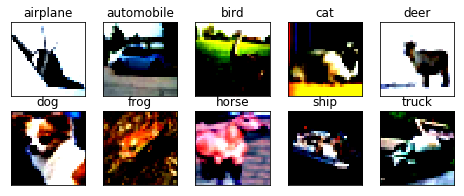

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig = plt.figure(figsize = (8,3))
for i in range (num_classes):
  ax = fig.add_subplot(2, 5, 1+i, xticks=[], yticks=[])
  idx = np.where(train_labels[:]==i)[0]
  features_idx = train_features[idx, ::]
  img_num = np.random.randint(features_idx.shape[0])
  im = features_idx[img_num]
  ax.set_title(class_names[i])
  plt.imshow(im)
plt.show()

###Function to Plot Model History Graph with Accuracy vs Loss

In [0]:
def plot_model_history(model_history):
  fig, axs = plt.subplots(1,2,figsize=(15,5))
  # summarize history for accuracy
  axs[0].plot(range(1, len(model_history.history['acc'])+1), model_history.history['acc'])
  axs[0].plot(range(1, len(model_history.history['val_acc'])+1), model_history.history['val_acc'])
  axs[0].set_title('Model_Accuracy')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_xlabel('Epoch')
  axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1), len(model_history.history['acc'])/10)
  axs[0].legend(['train','val'], loc='best')
  
  #summarize history for loss
  axs[1].plot(range(1, len(model_history.history['loss'])+1), model_history.history['loss'])
  axs[1].plot(range(1, len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
  axs[1].set_title('Model_Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1), len(model_history.history['loss'])/10)
  axs[1].legend(['train','val'], loc='best')
  plt.show()

In [0]:
def accuracy(test_x, test_y, model):
  result = model.predict(test_x)
  predicted_class = np.argmax(result, axis=1)
  true_class = np.argmax(test_y, axis=1)
  num_correct = np.sum(predicted_class == true_class)
  accuracy = float(num_correct)/result.shape[0]
  return (accuracy*100)

##Define function of CutOut/Random Eraser

> p : the probability that random erasing is performed

> s_l, s_h : minimum / maximum proportion of erased area against input image

> r_1, r_2 : minimum / maximum aspect ratio of erased area

> v_l, v_h : minimum / maximum value for erased area

> pixel_level : pixel-level randomization for erased area

In [0]:
import numpy as np

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

###Rescaling of train & test features and converting 1D class to 10D class metrices

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# Convert 1-dimensional class arrays to 10-dimensional class matrices
train_labels = np_utils.to_categorical(train_labels, 10)
test_labels = np_utils.to_categorical(test_labels, 10)

##Define Model with SGD and Momentum and random LR to start training.
> Not used LR Finder

In [0]:
# Define the model
model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Convolution2D(10, 1, 1))

model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())

model1.add(Activation('softmax'))
## compile model
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False)
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#model1.compile(loss='categorical_crossentropy', optimizer='ADAM', metrics=['accuracy'])

W0720 08:50:15.496783 139904423978880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
W0720 08:50:15.537993 139904423978880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 08:50:15.548356 139904423978880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 08:50:15.609459 139904423978880 deprecation_wrapper.py

In [0]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

###Prepare model saving Directory in google Drive

In [0]:
# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_Assignment_11_beforeLR.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate decaying.
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

#callbacks = [checkpoint, lr_reducer]

##Usage of Learning Scheduler and callback to get best model with basic Image Agumentation 

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

batch_size = 128

def scheduler(epoch, lr):
  return round(0.0075 * 1/(1 + 0.319 * epoch), 10)

#lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(train_features.shape[0]/batch_size))

datagen = ImageDataGenerator(zoom_range=0.0,
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1))

# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                 callbacks=[checkpoint, LearningRateScheduler(scheduler, verbose=1)])

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model1))

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0075.
  2/390 [..............................] - ETA: 34s - loss: 0.5144 - acc: 0.8438

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`


389/390 [============================>.] - ETA: 0s - loss: 0.9759 - acc: 0.6703

KeyboardInterrupt: ignored

###Reload Pre-trained Model from colab local drive.

In [0]:
from keras.models import load_model
#content/drive/My Drive/SOAI/EVA/Session9/cifar10_model_Ass_9A.hdf5
model = load_model('/content/drive/My Drive/SOAI/EVA/session11/cifar10_Assignment_11_beforeLR.h5')
score = model.evaluate(test_features, test_labels, verbose=0)
y_pred = model.predict(test_features)
print(score)

W0720 08:52:08.617170 139904423978880 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[0.6022384484291077, 0.8139]


###Save Model in Google Drive using Google Authentication

In [0]:
!pip install -U -q PyDrive
!pip install h5py pyyaml
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 
!rm -r /tmp/colab_util_repo
from colab_util import *
drive_handler = GoogleDriveHandler()

     |████████████████████████████████| 993kB 2.8MB/s 
Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


###Upload Model in Drive location

In [0]:
drive_handler.upload('/content/saved_models/cifar10_Assignment_11_beforeLR.h5', parent_path='/SOAI/EVA/session11')

'1nD8q5Y0BMTxUzI1-90C5PUHVnv1fSmrZ'

###Download Model from drive Location

In [0]:
drive_handler.download('cifar10_Assignment_11_beforeLR.h5', target_path='/SOAI/EVA/session11/cifar10_Assignment_11_beforeLR.h5')

##Define Model which helps to find Starting LR  

###After Adding LR Finder:

In [0]:
# Define the model
model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Convolution2D(32, 1, 1))

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Convolution2D(32, 1, 1))

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Convolution2D(10, 1, 1))

model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())

model1.add(Activation('softmax'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same"

###Define LR Finder Class which will use to give Starting LR to Model

In [0]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        k.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        k.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

###Compile Model and apply LR finder to get starting learning rate

In [0]:
# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_Assignment_11_AfterLR.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate decaying.
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#def scheduler(epoch, lr):
#  return round(0.0075 * 1/(1 + 0.319 * epoch), 10)

batch_size=128

lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(train_features.shape[0]/batch_size))

print(lr_finder)
## compile model
sgd = optimizers.SGD(decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

###Start Train Model in intial epoch model will stop and give idea of best starting lr to train model

In [0]:
model1.fit(train_features,
           train_labels,
           batch_size=64,
           nb_epoch=20, verbose=1,
           validation_data=(test_features,test_labels),
           callbacks=[lr_finder])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.
W0716 03:57:41.389261 139739345729408 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
23296/50000 [============>.................] - ETA: 21s - loss: 3.2779 - acc: 0.2356

###Plotting Learning and Loss with Different Criteria: Choose Starting LR from below Plots
> 1. Normal LR
> 2. Smooth LR
> 3. Normal Loss
> 4. Smooth Loss

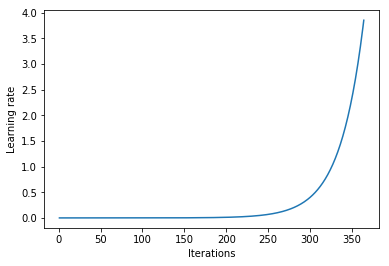

In [0]:
lr_finder.plot_lr()

###These Below Graph give starting LR which will use future models

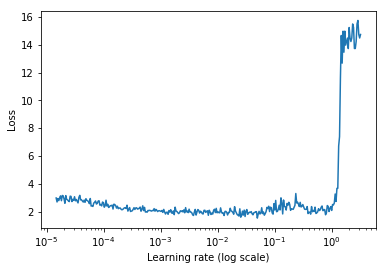

In [0]:
lr_finder.plot()

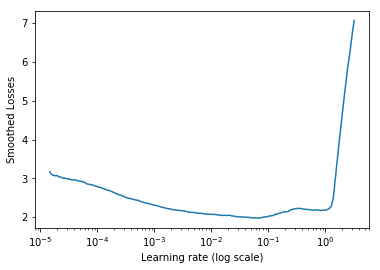

In [0]:
lr_finder.plot_smoothed_loss()

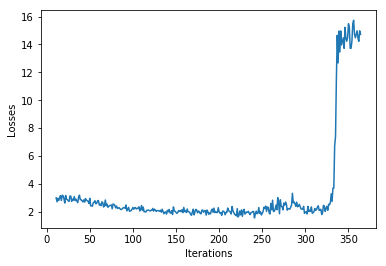

In [0]:
lr_finder.plot_loss()

##Define model again but these time using Starting LR in SGD Optimizer with Momentum 

###LR Finder gave Starting Learning Rate as .04 

In [0]:
# Define the model
model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Convolution2D(32, 1, 1))

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Convolution2D(32, 1, 1))

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Convolution2D(10, 1, 1))

model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())

model1.add(Activation('softmax'))
## compile model
sgd = optimizers.SGD(lr=0.04, decay=1e-6, momentum=0.9, nesterov=False)
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., p

In [0]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [0]:
# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_Assignment_11_WithLR.hdf5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate decaying.
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

Epoch 1/100
  2/390 [..............................] - ETA: 32s - loss: 0.6913 - acc: 0.8477

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  app.launch_new_instance()


390/390 [==============================] - 26s 66ms/step - loss: 0.6244 - acc: 0.8624 - val_loss: 7.1732 - val_acc: 0.1029

Epoch 00001: val_acc improved from -inf to 0.10290, saving model to /content/saved_models/cifar10_Assignment_11_WithLR.hdf5
Epoch 2/100
390/390 [==============================] - 25s 65ms/step - loss: 0.6204 - acc: 0.8618 - val_loss: 2.8921 - val_acc: 0.2664

Epoch 00002: val_acc improved from 0.10290 to 0.26640, saving model to /content/saved_models/cifar10_Assignment_11_WithLR.hdf5
Epoch 3/100
390/390 [==============================] - 26s 66ms/step - loss: 0.6350 - acc: 0.8570 - val_loss: 3.5859 - val_acc: 0.1485

Epoch 00003: val_acc did not improve from 0.26640
Epoch 4/100
390/390 [==============================] - 26s 66ms/step - loss: 0.6064 - acc: 0.8680 - val_loss: 2.8746 - val_acc: 0.3000

Epoch 00004: val_acc improved from 0.26640 to 0.30000, saving model to /content/saved_models/cifar10_Assignment_11_WithLR.hdf5
Epoch 5/100
390/390 [===================

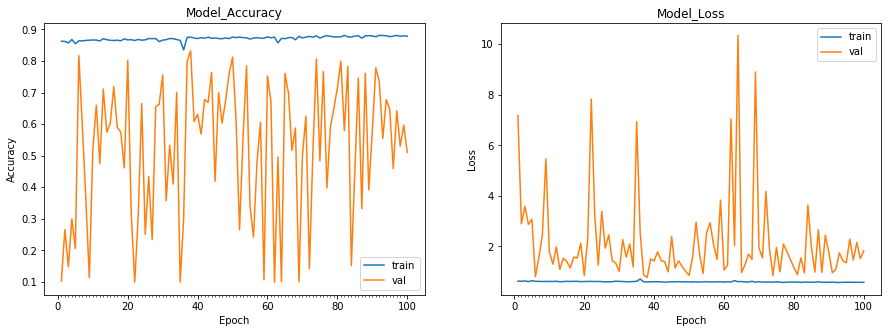

Accuracy on test data is: 51.06


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

batch_size = 128

datagen = ImageDataGenerator(zoom_range=0.0,
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1))

# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                 callbacks=[checkpoint])

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model1))

Model took 2570.84 seconds to train


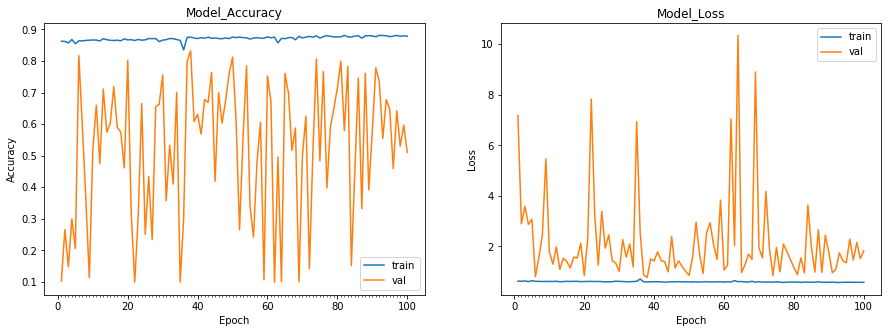

Accuracy on test data is: 51.06


In [0]:
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model1))

In [0]:
!pip install -U -q PyDrive
!pip install h5py pyyaml
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 
!rm -r /tmp/colab_util_repo
from colab_util import *
drive_handler = GoogleDriveHandler()

Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [0]:
drive_handler.upload('/content/saved_models/cifar10_Assignment_11_WithLR.hdf5', parent_path='/SOAI/EVA/session11')

W0716 06:01:05.306222 139739345729408 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

'179OHr3MkbkUdywvzFhHpaVHL6XVbQGUu'

In [0]:
drive_handler.download('cifar10_Assignment_11_WithLR.hdf5', target_path='/SOAI/EVA/session11/cifar10_Assignment_11_WithLR.hdf5')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


###Load Pre-Trained Model with CutOut and Starting LR which got from LR Finder

In [0]:
from keras.models import load_model
#content/drive/My Drive/SOAI/EVA/Session9/cifar10_model_Ass_9A.hdf5
model = load_model('/content/drive/My Drive//SOAI/EVA/session11/cifar10_Assignment_11_WithLR.hdf5')
score = model.evaluate(test_features, test_labels, verbose=0)
y_pred = model.predict(test_features)
print(score)

[0.7699254454612732, 0.8322]


###Getting all Misclassified Image indexes

In [0]:
y_pred = model.predict(test_features)
# getting index of all misclasified images
img_index = []
for i in range(1,test_labels.shape[0]):
  if np.argmax(y_pred[i])!=np.argmax(test_labels[i]):
    img_index.append(i)

###After Normalization, Storing misclassified as Actual , Predicated  output printing those results.

In [0]:
def image_reconstract(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x
  
# Storing 12 misclassified images into a variable after converting them  into 0-255 scale. Also, storing actual and predicted output values for those images
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
img_actual = [] 
img_actual_value = []
img_pred_value = []
for i in range(1,13):
    img_req = np.array(test_features[img_index[i-1]]).astype(np.float64)
    img_req = image_reconstract(img_req)
    img_actual.append(img_req)
    img_actual_value.append(class_names[np.argmax(test_labels[img_index[i-1]])])
    img_pred_value.append(class_names[np.argmax(y_pred[img_index[i-1]])])

###Plotting those Actual Results

In [0]:
# Plotting all 12 images    
row = 4
col = 3
fig=plt.figure(figsize=(10, 10))
for i in range(0,row*col):
  fig.add_subplot(row,col,i+1)
  plt.imshow(img_actual[i]) 
  plt.title('Actual:'+str(img_actual_value[i])+'& Predicted:'+str(img_pred_value[i]))
  plt.xticks([])
  plt.yticks([])
plt.show() 

NameError: ignored

###Define GradCam Apply on Actual results 

In [0]:
def image_reconstract(x):
  # normalize tensor: center on 0., ensure std is 0.1
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1

  # clip to [0, 1]
  x += 0.5
  x = np.clip(x, 0, 1)

  # convert to RGB array
  x *= 255
  #x = x.transpose((1, 2, 0))
  x = np.clip(x, 0, 255).astype('uint8')
  return x
  
import cv2 
def applygradCAM(image):
  # expanding dimension for prediction
  x = np.expand_dims(image, axis=0)
  
  # prediction of the image
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  
  # Getting the output of the last convolutional layer 
  last_conv_layer = model.get_layer("conv2d_14")
  
  # Claculating the gradients
  grads = k.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = k.mean(grads, axis=(0, 1, 2))
  iterate = k.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  # Creating the heatmap
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap) 
  
  # Resize heatmap to original image size
  heatmap = cv2.resize(heatmap, (x.shape[1], x.shape[2]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  # Creating the superimposed Image
  superimposed_img = cv2.addWeighted(image_reconstract(image), 0.6, heatmap, 0.4, 0)
  return superimposed_img

###Apply gradcam on test features

In [0]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(12,4))

img_gradCam = [] 
img_actual_value = []
img_pred_value = []
for i in range(1,26):
    img_req_grad = applygradCAM(test_features[img_index[i-1]])
    img_gradCam.append(img_req_grad)
    img_actual_value.append(class_names[np.argmax(test_labels[img_index[i-1]])])
    img_pred_value.append(class_names[np.argmax(y_pred[img_index[i-1]])])

<Figure size 864x288 with 0 Axes>

###Plotting GradCam Results as Actual and Predicted.

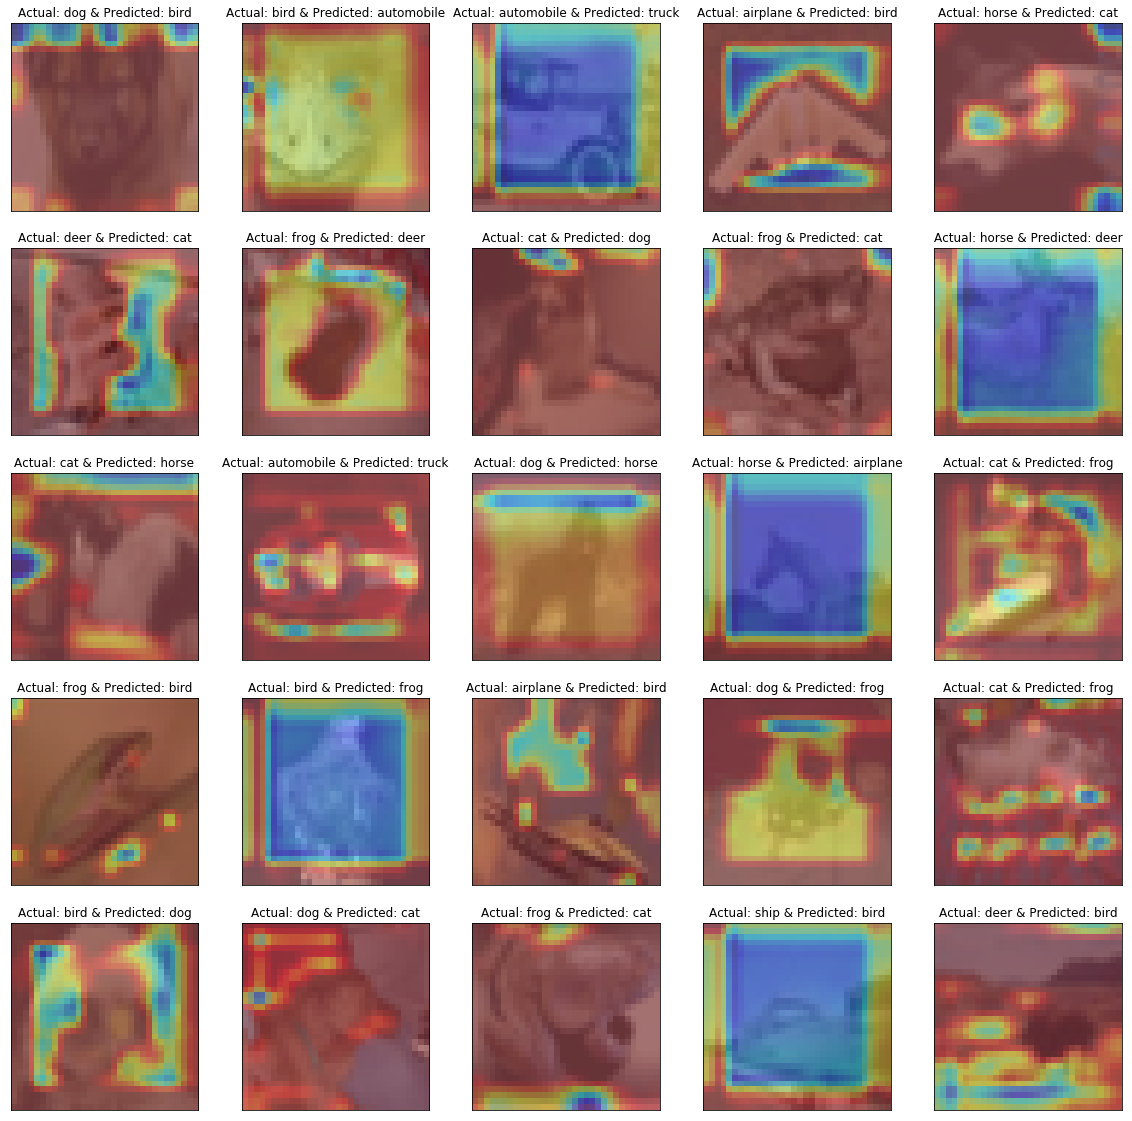

In [0]:
# Plotting all 10 images    
row = 5
col = 5
fig=plt.figure(figsize=(20, 20))
for i in range(0,row*col):
  fig.add_subplot(row,col,i+1)
  plt.imshow(img_gradCam[i]) 
  plt.title('Actual: '+str(img_actual_value[i])+' & Predicted: '+str(img_pred_value[i]))
  plt.xticks([])
  plt.yticks([])
plt.show() 